In [1]:
import sys
import os

# 현재 파일의 절대 경로
current_path = os.getcwd()
# 프로젝트의 루트 디렉토리 (현재 경로의 상위 디렉토리)
project_root = os.path.abspath(os.path.join(current_path, ".."))

# PYTHONPATH에 추가
if project_root not in sys.path:
    sys.path.insert(0, project_root)

## Part 1. 기본 챗봇 구축

### 1-1. 챗봇 구축

- StateGraph는 Node와 Edge로 구성되며, 각 Node는 특정 작업을 수행하고 상태를 업데이트 한다.
    
    1. State: 애플리케이션의 현재 상태를 나타내는 공유 데이터 구조
        - 역할: 전체 워크플로우의 컨텍스트 유지. 노드간 정보 공유. 
        - TypedDict 또는 Pydantic BaseModel로 정의한다.
    2. Nodes: 실제 작업을 수행하는 Python 함수들
        - 역할: 특정 로직 수행(예: LLM 호출, 도구 사용). 상태 업데이트.
        - 입력으로 현재 상태를 받고, 업데이트된 상태를 반환한다.
    3. Edges: 노드 간의 연결을 정의하는 요소
        - 역할: 워크플로우의 흐름제어. 조건부 라우팅 가능. 다음에 실행할 노드 결정.

- 더 쉬운 말로 이해하기 (LangGraph: 거대한 자동차 공장)

    1. State(상태): 공장 전체의 현재 상황을 나타내는 중앙 관제 시스템. 그래프 내에서는 현재의 상태가 모든 직원들에게 공유된다.
    2. Nodes(노드): 각 노드는 공장 내의 특정 작업 스테이션. 각 스테이션은 자신의 고유한 작업을 수행한다.
    3. Edges(엣지): 각 작업 스테이션 간의 정보 전달 시스템. 한 스테이션의 작업이 끝나면 다음 스테이션으로 제품이나 정보를 전달한다.

    - 공장 가동 시 모든 스테이션은 대기 상태(inactive)로 시작한다. 작업할 제품이나 정보가 도착하면 스테이션이 활성화(active)되어 작업을 시작한다.
    - 작업을 마치면 결과물을 다음 스테이션으로 보내고 다시 대기상태(inactive) 상태로 돌아간다.
    - 모든 스테이션의 작업이 끝나고 더 이상 처리할 제품이 없으면 공장 가동이 종료된다.

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

- graph_builder.add_node("chatbot", chatbot)

In [3]:
# from langchain_community.chat_models import ChatClovaX
from langchain_openai import ChatOpenAI

from config.api_config import (CLOVA_API_KEY, CLOVA_API_GATEWAY_KEY, TAVILY_API_KEY, OPENAI_API_KEY)

os.environ["NCP_CLOVASTUDIO_API_KEY"] = CLOVA_API_KEY
os.environ["NCP_APIGW_API_KEY"] = CLOVA_API_GATEWAY_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# llm = ChatClovaX(model="HCX-003")
llm = ChatOpenAI(model="gpt-3.5-turbo")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

- graph_builder.add_edge(START, "chatbot")
- graph_builder.add_edge("chatbot", END)

  --> graph_builder.compile()

In [4]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

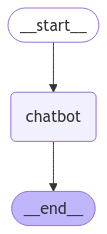

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 1-2. 챗봇 실행

In [6]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    
    except:
        # input이 이상할 때
        user_input = "What do you know about LangGraph?"
        print("User: "+user_input)
        stream_graph_updates(user_input)
        break


Assistant: 네이버는 한국의 대표적인 포털 사이트이며, 검색 엔진, 뉴스, 블로그, 지식인, 카페, 지도, 쇼핑 등 다양한 서비스를 제공하는 인터넷 기업입니다. 또한, 네이버는 한국의 대표적인 인터넷 기업인 네이버 코퍼레이션의 대표 브랜드이기도 합니다. 현재 네이버는 한국을 넘어 글로벌 시장에서도 다양한 서비스를 제공하고 있습니다.
Goodbye!


## Part 2. tools로 챗봇 향상

In [7]:
# !pip install -U tavily-python langchain_community

In [7]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
import json

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import ToolMessage
# from langchain_community.chat_models import ChatClovaX
from langchain_openai import ChatOpenAI
from config.api_config import (CLOVA_API_KEY, CLOVA_API_GATEWAY_KEY, TAVILY_API_KEY, OPENAI_API_KEY)

os.environ["NCP_CLOVASTUDIO_API_KEY"] = CLOVA_API_KEY
os.environ["NCP_APIGW_API_KEY"] = CLOVA_API_GATEWAY_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

### 2-1. tool 정의

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results = 2) # tool : Tavily 검색 도구 -> 챗봇이 실시간 정보를 검색할 수 있게 함
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [9]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# llm = ChatClovaX(model="HCX-003")
llm = ChatOpenAI(model="gpt-3.5-turbo")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools) # llm에 tool 연결


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot) # 노드 1

In [10]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node) # 노드 2

### 2-2. 조건부 라우팅 구현
- 조건부 라우팅은 AI가 대화 중에 "결정"을 내리는 방법이다. <br>
    마치 우리가 대화할 떄 상대방의 말에 따라 다르게 대응하는 것처럼, AI도 입력에 따라 다른 행동을 할 수 있다.


- 조건부 라우팅은 다음과 같은 이유로 AI 시스템에서 중요하다.

    1. 유연성: 다양한 사용자 입력에 대응하여 적절한 처리 경로를 선택할 수 있다.
    2. 효율성: 필요한 경우에만 특정 노드나 기능을 실행하여 리소스를 절약한다.
    3. 복잡한 워크플로우: 다단계 의사결정 프로세스를 구현할 수 있다.
    4. 사용자 경험 개선: 상황에 따라 다른 응답을 제공하여 더 자연스러운 대화를 가능하게 한다.

In [11]:
def route_tools(
    state: State,
):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# 조건부 엣지의 정의 (아래의 display 이미지에서 점선에 해당됨)
graph_builder.add_conditional_edges(
    "chatbot", # 조건 검사를 시작할 노드
    route_tools, # 현재 상태를 평가하고 다음 노드를 결정하는 함수
    {"tools": "tools", END: END}
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

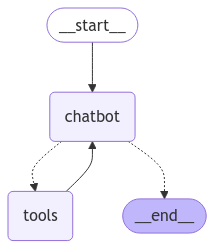

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

### 2-3. 챗봇 실행

In [12]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://play.google.com/store/apps/dev?id=6225315284672069550&hl=en-US", "content": "\ub124\uc774\ubc84 - NAVER. NAVER Corp. Enjoy Naver App's special search features and various services. Smartphones. 3.7star. 562K reviews. 100M+ Downloads. Everyone. info. Install. Enjoy Naver App's special search features and various services. Smartphones. More by NAVER Corp. BAND - App for all groups."}, {"url": "https://play.google.com/store/apps/details?id=com.nhn.android.search&hl=en-US", "content": "\ub124\uc774\ubc84 - NAVER. NAVER Corp. 3.7star. 562K reviews. 100M+ Downloads. Everyone. info. Install. Share. Add to wishlist. About this app. arrow_forward. A wealth of information optimized for mobile! Experience the NAVER app, refreshed daily. The NAVER app offers five spaces tailored to different content types. Your favorite is in \"Home Feed"}]
Assistant: 네이버는 NAVER Corp.에서 제공하는 앱으로, 특별한 검색 기능과 다양한 서비스를 제공합니다. 리뷰 수는 562,000개 이상이고 다운로드 수는 1억 건 이상입니다. 네이버 앱은 매일 새